In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

           0       0.82      0.80      0.81       162
           1       0.84      0.86      0.85       199

    accuracy                           0.83       361
   macro avg       0.83      0.83      0.83       361
weighted avg       0.83      0.83      0.83       361



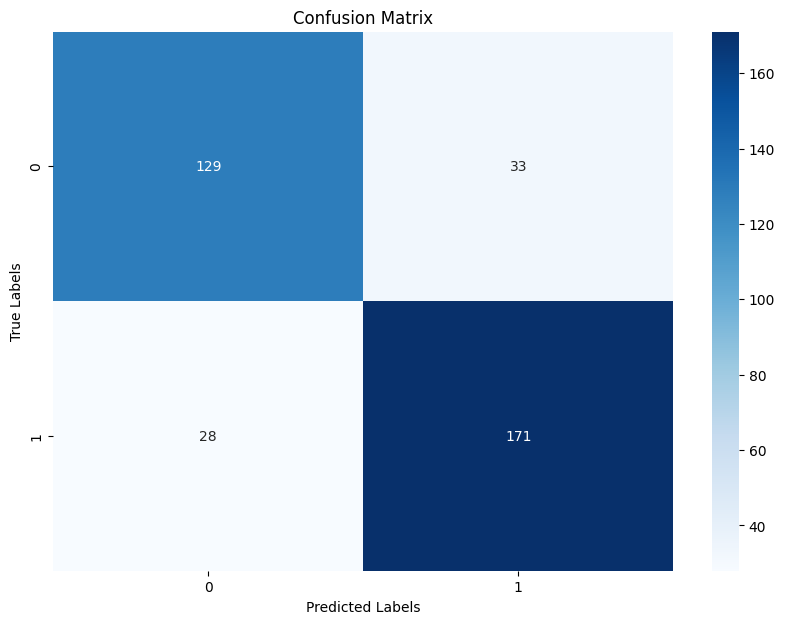

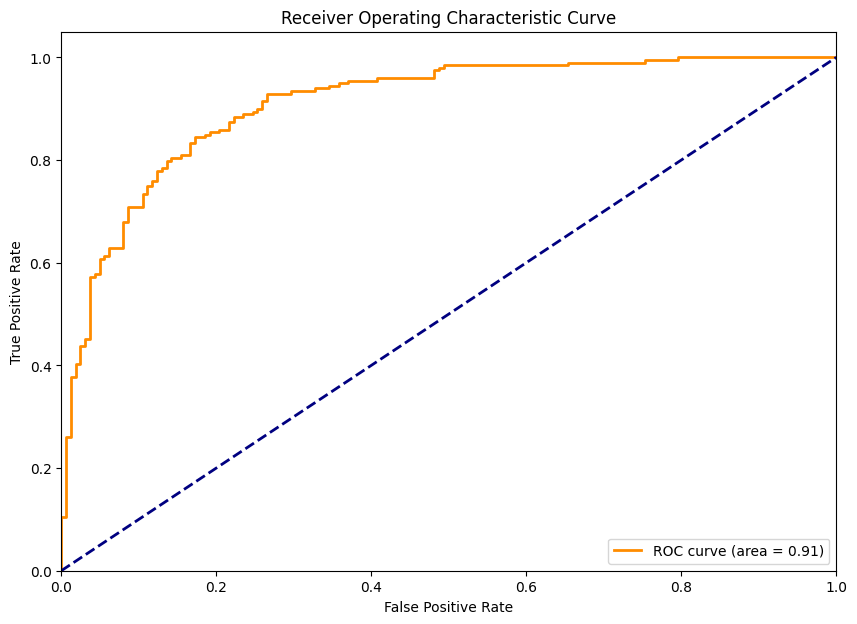

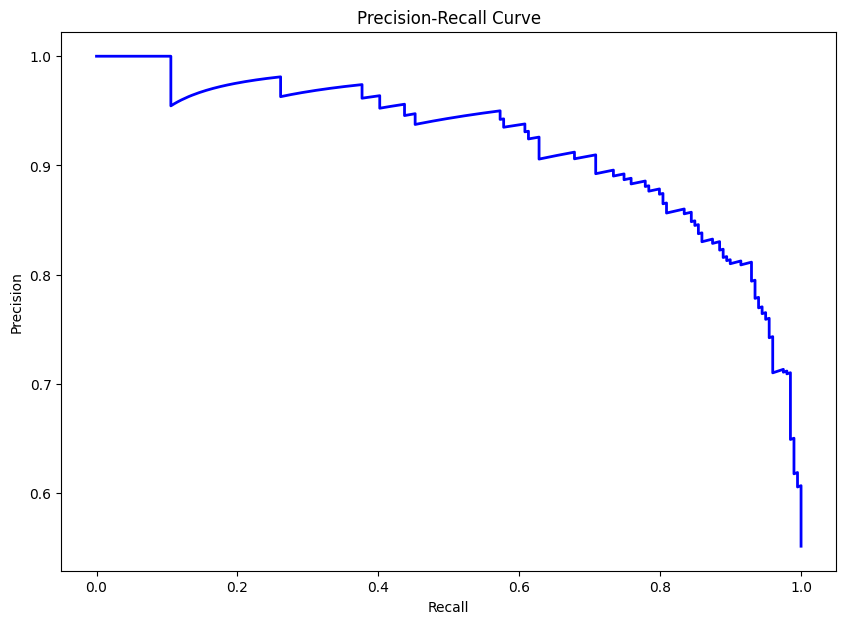

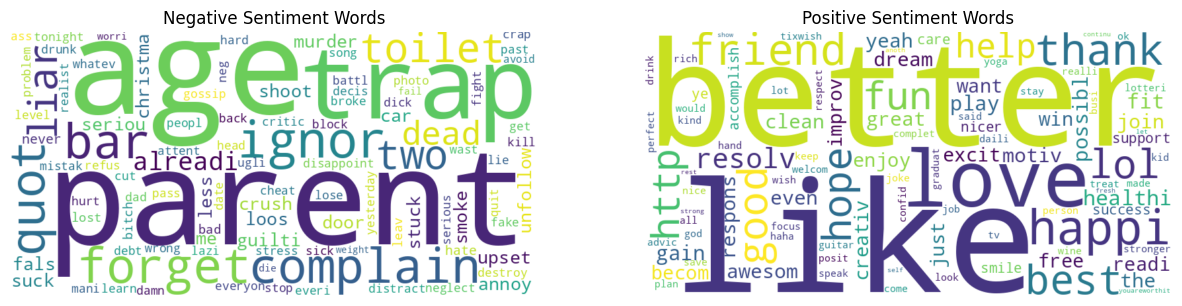

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/GoogleColab/web social media anlysis and visualization/new_balanced_sentiment_dataset.csv')

# Preprocess the data
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [stemmer.stem(word.lower()) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned_tokens)

# Apply the cleaning function to your text data column
df['cleaned_text1'] = df['text'].apply(clean_text)

# Encode the labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['sentiment_type'])  # Assuming label column is named 'sentiment_type'

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_text1'])
y = df['encoded_label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probabilities for positive class
print(classification_report(y_test, y_pred))

# Extract feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='coefficient')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Create word clouds for positive and negative sentiments
negative_words = feature_importance.head(100).set_index('feature').to_dict()['coefficient']
positive_words = feature_importance.tail(100).set_index('feature').to_dict()['coefficient']
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_words)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_words)

# Plotting the word clouds
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Sentiment Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Sentiment Words')
plt.axis('off')
plt.show()
